>
> # MaaSSim tutorial

 ### quickstart

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [3]:
import pandas as pd

In [4]:
import ExMAS

In [5]:
params = get_config('../../data/config/delft.json')  # load configuration

In [6]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 1 # 1 hour of simulation
params.nP = 50 # reuqests (and passengers)
params.nV = 20 # vehicles

In [9]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.0005
params.shareability.comm_rate = 0.2

In [10]:
inData = load_G(inData, params)  # load network graph 

In [11]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [12]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

11-07-23 22:21:24-INFO-Initializing pairwise trip shareability between 50 and 50 trips.
11-07-23 22:21:24-INFO-creating combinations
11-07-23 22:21:24-INFO-2450	 nR*(nR-1)
11-07-23 22:21:24-INFO-Reduction of feasible pairs by 98.78%
11-07-23 22:21:24-INFO-Degree 2 	Completed
11-07-23 22:21:24-INFO-trips to extend at degree 2 : 66
11-07-23 22:21:24-INFO-At degree 2 feasible extensions found out of 6 searched
11-07-23 22:21:24-INFO-Degree 3 	Completed
11-07-23 22:21:24-INFO-trips to extend at degree 3 : 6
11-07-23 22:21:24-INFO-At degree 3 feasible extensions found out of 0 searched
11-07-23 22:21:24-INFO-Degree 4 	Completed
11-07-23 22:21:24-INFO-Max degree reached 4
11-07-23 22:21:24-INFO-Trips still possible to extend at degree 4 : 0


In [13]:
inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

11-07-23 22:21:28-INFO-Matching 50 trips to 122 rides in order to min u_pax
11-07-23 22:21:28-INFO-Problem solution: Optimal. 
Total costs for single trips:            232 
reduced by matching to:                  209


In [14]:
inData.sblts.rides.loc[inData.requests.loc[3].rides]

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
3,[3],3.43600,185,1,[3.436],"[78, 185]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44820007, 1421472391]","[None, 3, 3]",node time req_id od 0 ...,185,1.85,2.78850,0.55770,2.23080
86,"[0, 3]",7.32095,412,21,"[4.484024999999999, 2.836925]","[-9.5, 97, 185, 130]","[0, 3]","[3, 0]",2,86,...,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44838367, 44820007, 1421472391, 4244308...","[None, 0, 3, 3, 0]",node time req_id od 0 ...,412,4.12,4.51815,0.90363,3.61452


In [15]:
inData.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,rides,sim_schedule
0,0,44838367,4244308801,2023-07-11 21:51:28,NaN,0 days 00:40:44,2023-07-11 22:32:12,NaN,True,NaN,2444,0,86,0,"[0, 50, 86]",node time req_id od 0 ...
1,1,1448535767,2323108159,2023-07-11 21:51:39,NaN,0 days 01:18:59,2023-07-11 23:10:38,NaN,True,NaN,4739,0,52,0,"[1, 51, 52, 53, 87]",node time req_id od 0 ...
2,2,1530303649,1569858134,2023-07-11 21:52:14,NaN,0 days 00:35:44,2023-07-11 22:27:58,NaN,True,NaN,2144,0,54,0,"[2, 54]",node time req_id od 0 ...
3,3,44820007,1421472391,2023-07-11 21:52:46,NaN,0 days 00:30:59,2023-07-11 22:23:45,NaN,True,NaN,1859,0,86,0,"[3, 86]",node time req_id od 0 ...
4,4,1391531638,44825833,2023-07-11 21:52:54,NaN,0 days 00:26:49,2023-07-11 22:19:43,NaN,True,NaN,1609,0,56,0,"[4, 55, 56]",node time req_id od 0 ...
5,5,1552650958,271397035,2023-07-11 21:55:23,NaN,0 days 01:14:10,2023-07-11 23:09:33,NaN,True,NaN,4450,0,57,0,"[5, 57]",node time req_id od 0 ...
6,6,44808578,44772082,2023-07-11 21:55:41,NaN,0 days 00:50:44,2023-07-11 22:46:25,NaN,True,NaN,3044,0,54,0,"[6, 50, 54, 55]",node time req_id od 0 ...
7,7,44831875,1391417418,2023-07-11 21:57:25,NaN,0 days 00:26:42,2023-07-11 22:24:07,NaN,True,NaN,1602,0,56,0,"[7, 51, 56, 58, 87]",node time req_id od 0 ...
8,8,44864984,44834064,2023-07-11 21:59:46,NaN,0 days 00:36:05,2023-07-11 22:35:51,NaN,True,NaN,2165,0,52,0,"[8, 52, 58]",node time req_id od 0 ...
9,9,44814943,1558185453,2023-07-11 21:59:50,NaN,0 days 01:14:50,2023-07-11 23:14:40,NaN,True,NaN,4490,0,88,0,"[9, 53, 88, 89]",node time req_id od 0 ...


In [21]:
params.kpi = 1

simulate

In [22]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

11-07-23 22:25:17-WARNING-Setting up 1h simulation at 2023-07-11 21:51:28 for 20 vehicles and 50 passengers in Delft, Netherlands
0.0005
11-07-23 22:25:17-CRITICAL-this is request 0 with [0, 50, 86] available rides.
11-07-23 22:25:17-CRITICAL-ride 0 available [1]
11-07-23 22:25:17-CRITICAL-ride 50 available [1, 0]
11-07-23 22:25:17-CRITICAL-ride 86 available [1, 0]
11-07-23 22:25:17-CRITICAL-this is reuqest 0 with [0, 50, 86] still available rides.
11-07-23 22:25:17-CRITICAL-vehicle 1 has 3 choices
0.0005
11-07-23 22:25:17-CRITICAL-this is request 1 with [1, 51, 52, 53, 87] available rides.
11-07-23 22:25:17-CRITICAL-ride 1 available [1]
11-07-23 22:25:17-CRITICAL-ride 51 available [1, 0]
11-07-23 22:25:17-CRITICAL-ride 52 available [1, 0]
11-07-23 22:25:17-CRITICAL-ride 53 available [1, 0]
11-07-23 22:25:17-CRITICAL-ride 87 available [1, 0]
11-07-23 22:25:17-CRITICAL-this is reuqest 1 with [1, 51, 52, 53, 87] still available rides.
11-07-23 22:25:17-CRITICAL-vehicle 11 has 5 choices
0

<AxesSubplot:>

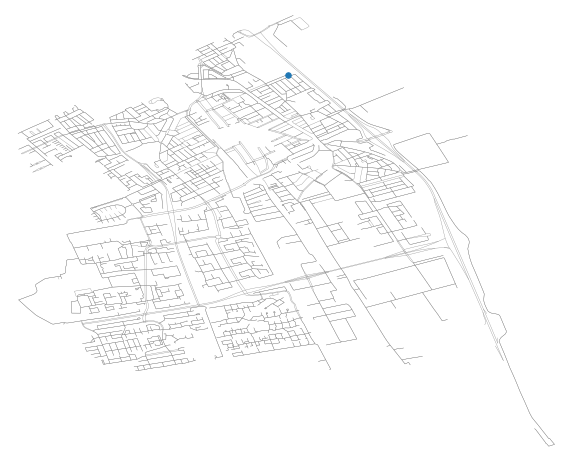

In [23]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==19], lw = 1)

In [24]:
params.shareability.share = 0
sim2 = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

11-07-23 22:25:41-WARNING-Setting up 1h simulation at 2023-07-11 21:51:28 for 20 vehicles and 50 passengers in Delft, Netherlands
0.0005
11-07-23 22:25:42-CRITICAL-this is request 0 with [0, 50, 86] available rides.
11-07-23 22:25:42-CRITICAL-ride 0 available [1]
11-07-23 22:25:42-CRITICAL-ride 50 available [1, 0]
11-07-23 22:25:42-CRITICAL-ride 86 available [1, 0]
11-07-23 22:25:42-CRITICAL-this is reuqest 0 with [0, 50, 86] still available rides.
11-07-23 22:25:42-CRITICAL-vehicle 1 has 3 choices
0.0005
11-07-23 22:25:42-CRITICAL-this is request 1 with [1, 51, 52, 53, 87] available rides.
11-07-23 22:25:42-CRITICAL-ride 1 available [1]
11-07-23 22:25:42-CRITICAL-ride 51 available [1, 0]
11-07-23 22:25:42-CRITICAL-ride 52 available [1, 0]
11-07-23 22:25:42-CRITICAL-ride 53 available [1, 0]
11-07-23 22:25:42-CRITICAL-ride 87 available [1, 0]
11-07-23 22:25:42-CRITICAL-this is reuqest 1 with [1, 51, 52, 53, 87] still available rides.
11-07-23 22:25:42-CRITICAL-vehicle 12 has 5 choices
0

<AxesSubplot:>

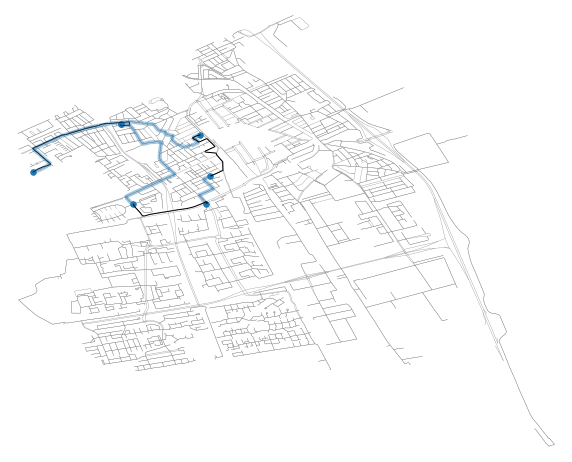

In [25]:
df = sim2.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()==1:
        break
plot_veh(inData.G, df[df.veh ==8], lw = 1)

-----

In [28]:
sim.vehs[1].rdf 

,0
indexes,"[0, 6]"
u_pax,9.6299
u_veh,723
kind,20
u_paxes,"[4.39075, 5.2391499999999995]"
...,...
driver_revenue,1.2804
pickup_dist,1547
trav_dist,1548.06
operating_cost,0.77403


In [27]:
pd.DataFrame(sim.vehs[1].myrides)

,veh,pos,t,event,paxes
0,1,4.481794e+07,0,STARTS_DAY,[]
1,1,4.481794e+07,0,OPENS_APP,[]
2,1,4.481794e+07,0,RECEIVES_REQUEST,[]
3,1,4.481794e+07,15,ACCEPTS_REQUEST,[]
4,1,4.481794e+07,35,IS_ACCEPTED_BY_TRAVELLER,[None]
5,1,4.481794e+07,113,IS_ACCEPTED_BY_TRAVELLER,[None]
6,1,4.483837e+07,183,ARRIVES_AT_PICKUP,[]
7,1,4.483837e+07,183,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,4.483837e+07,213,DEPARTS_FROM_PICKUP,[0]
9,1,4.482001e+07,310,ARRIVES_AT_PICKUP,[0]
